In [68]:
import pandas as pd
import numpy as np
import folium
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering, MiniBatchKMeans
from sklearn.metrics import pairwise_distances

In [7]:
data = pd.read_csv('data.csv')
data.head()

,name,location
0,kanggun0,eighth
1,kanggun1,revelle
2,kanggun2,muir
3,kanggun3,muir
4,kanggun4,warren


In [10]:
data = data.replace('erc', 'roosevelt')

In [11]:
# Coordinates for locations near/in UCSD
location_coords = {
    'eighth': (32.872170599876476, -117.24236212576339),
    'revelle': (32.87549842936363, -117.24185206521258),
    'muir': (32.87862074208326, -117.24199908929927),
    'sixth': (32.88093533596453, -117.24207768929914),
    'marshall': (32.88332447048564, -117.2431286874465),
    'warren': (32.88250999892929, -117.23423247088701),
    'roosevelt': (32.88629047401013, -117.24216105675765),
    'seventh': (32.88824105411043, -117.24204057210201),
    'pepper canyon': (32.87855815307487, -117.23182190956248),
    'rita': (32.8731998381307, -117.23508676165143),
    'costa': (32.87052184118228, -117.21678300031834),
    'regents': (32.87445867128256, -117.21711298933135),
    'la regencia': (32.8643885892427, -117.2247437382329)
}

map_ucsd = folium.Map(location=[32.8788, -117.2359], zoom_start=14)

In [33]:
for _, row in data.iterrows():
    location_name = row['location'].lower()

    if location_name in location_coords:
        coords = location_coords[location_name]
        folium.Marker(location=coords, popup=row['name'], tooltip=location_name.title()).add_to(map_ucsd)

map_ucsd

In [19]:
data = data.assign(coords=data['location'].map(location_coords))
data.head()

,name,location,coords
0,kanggun0,eighth,"(32.872170599876476, -117.24236212576339)"
1,kanggun1,revelle,"(32.87549842936363, -117.24185206521258)"
2,kanggun2,muir,"(32.87862074208326, -117.24199908929927)"
3,kanggun3,muir,"(32.87862074208326, -117.24199908929927)"
4,kanggun4,warren,"(32.88250999892929, -117.23423247088701)"


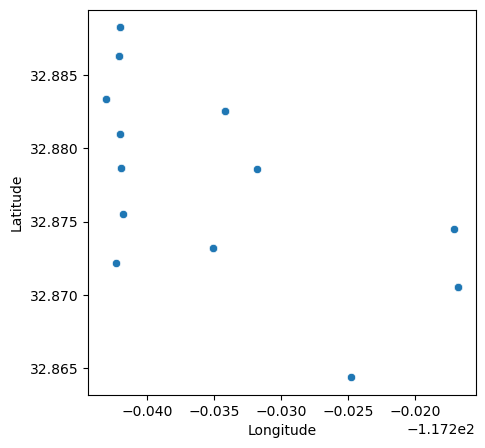

In [32]:
plot_data = pd.DataFrame({
    'Longitude': data['coords'].apply(lambda x: x[1] if isinstance(x, tuple) and len(x) > 0 else None),
    'Latitude': data['coords'].apply(lambda x: x[0] if isinstance(x, tuple) and len(x) > 0 else None)
})

plt.figure(figsize=(5, 5))
sns.scatterplot(data=plot_data, x='Longitude', y='Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [64]:
data_with_coords = data.dropna(subset=['coords'])
coordinates_array = np.array(data_with_coords['coords'].tolist())

def minimize_clusters_with_limit(coords, max_points_per_cluster=4):
    clustering = AgglomerativeClustering(n_clusters=1)
    labels = clustering.fit_predict(coords)
    
    while True:
        unique_labels, counts = np.unique(labels, return_counts=True)

        if np.all(counts <= max_points_per_cluster):
            break

        clusters_to_split = unique_labels[counts > max_points_per_cluster]

        for cluster in clusters_to_split:
            cluster_points = coords[labels == cluster]

            num_new_clusters = max(2, len(cluster_points) // max_points_per_cluster)

            kmeans_split = MiniBatchKMeans(n_clusters=num_new_clusters, random_state=42)
            new_labels = kmeans_split.fit_predict(cluster_points)

            max_label = labels.max()
            labels[labels == cluster] = max_label + new_labels + 1

    return labels

final_labels = minimize_clusters_with_limit(coordinates_array, max_points_per_cluster=4)

data_with_coords = data_with_coords.assign(cluster=final_labels)

data_with_coords.head()

,name,location,coords,cluster
0,kanggun0,eighth,"(32.872170599876476, -117.24236212576339)",3
1,kanggun1,revelle,"(32.87549842936363, -117.24185206521258)",3
2,kanggun2,muir,"(32.87862074208326, -117.24199908929927)",3
3,kanggun3,muir,"(32.87862074208326, -117.24199908929927)",3
4,kanggun4,warren,"(32.88250999892929, -117.23423247088701)",4


/var/folders/lt/n_z12_lx2cb6n9qf36pmd3x40000gn/T/ipykernel_10962/1783663243.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Cluster', loc='best')


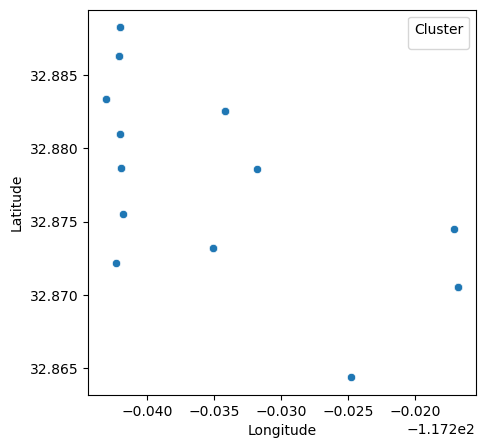

In [65]:
plot_data = pd.DataFrame({
    'Longitude': data['coords'].apply(lambda x: x[1] if isinstance(x, tuple) and len(x) > 0 else None),
    'Latitude': data['coords'].apply(lambda x: x[0] if isinstance(x, tuple) and len(x) > 0 else None),
    'Cluster': data_with_coords['cluster']
})

plt.figure(figsize=(5, 5))
sns.scatterplot(data=plot_data, x='Longitude', y='Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Cluster', loc='best')
plt.show()

In [66]:
data_with_coords

,name,location,coords,cluster
0,kanggun0,eighth,"(32.872170599876476, -117.24236212576339)",3
1,kanggun1,revelle,"(32.87549842936363, -117.24185206521258)",3
2,kanggun2,muir,"(32.87862074208326, -117.24199908929927)",3
3,kanggun3,muir,"(32.87862074208326, -117.24199908929927)",3
4,kanggun4,warren,"(32.88250999892929, -117.23423247088701)",4
5,kanggun5,warren,"(32.88250999892929, -117.23423247088701)",4
6,kanggun6,warren,"(32.88250999892929, -117.23423247088701)",4
7,kanggun7,roosevelt,"(32.88629047401013, -117.24216105675765)",7
8,kanggun8,roosevelt,"(32.88629047401013, -117.24216105675765)",7
9,kanggun9,roosevelt,"(32.88629047401013, -117.24216105675765)",7


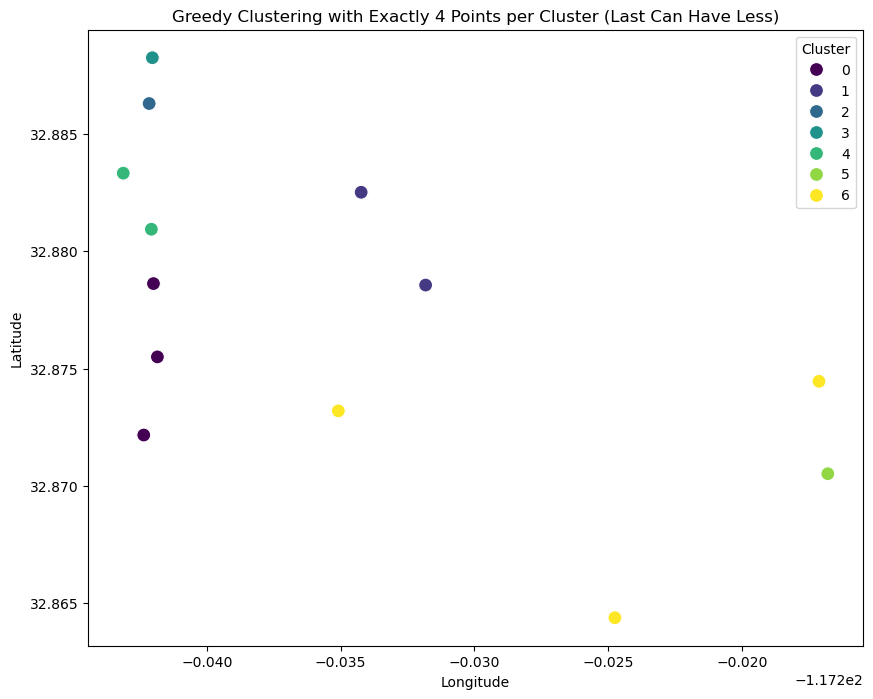

In [69]:
def greedy_clustering_exact_four(coords, max_points_per_cluster=4):
    # List to store cluster labels
    labels = -1 * np.ones(len(coords), dtype=int)
    
    # Keep track of which points are clustered
    clustered = np.zeros(len(coords), dtype=bool)
    
    current_cluster = 0
    
    # While there are unclustered points
    while not np.all(clustered):
        # Find unclustered points
        unclustered_indices = np.where(~clustered)[0]
        
        # If fewer than max_points_per_cluster points remain, form the last cluster
        if len(unclustered_indices) <= max_points_per_cluster:
            for idx in unclustered_indices:
                labels[idx] = current_cluster
            break
        
        # Otherwise, form a cluster with exactly max_points_per_cluster points
        current_point_idx = unclustered_indices[0]
        labels[current_point_idx] = current_cluster
        clustered[current_point_idx] = True
        points_in_cluster = [current_point_idx]
        
        while len(points_in_cluster) < max_points_per_cluster:
            # Update unclustered indices
            unclustered_indices = np.where(~clustered)[0]
            
            # Calculate distances to the current cluster
            distances = pairwise_distances(coords[points_in_cluster], coords[unclustered_indices])
            closest_point_idx = unclustered_indices[np.argmin(distances.min(axis=0))]
            
            # Add this point to the cluster
            labels[closest_point_idx] = current_cluster
            clustered[closest_point_idx] = True
            points_in_cluster.append(closest_point_idx)
        
        # Move to the next cluster
        current_cluster += 1
    
    return labels

# Apply the clustering approach to have clusters of exactly 4 points except the last
greedy_labels_exact_four = greedy_clustering_exact_four(coordinates_array, max_points_per_cluster=4)

# Add these cluster labels to the dataframe
data_with_coords['greedy_cluster_exact_four'] = greedy_labels_exact_four

# Plot using seaborn to visualize the clustering
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pd.DataFrame({'Longitude': coordinates_array[:, 1], 
                                   'Latitude': coordinates_array[:, 0], 
                                   'Cluster': greedy_labels_exact_four}), 
                x='Longitude', y='Latitude', hue='Cluster', palette='viridis', s=100)
plt.title('Greedy Clustering with Exactly 4 Points per Cluster (Last Can Have Less)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Cluster', loc='best')
plt.show()


In [71]:
data_with_coords.sort_values('location')

,name,location,coords,cluster,greedy_cluster_exact_four
21,kanggun21,costa,"(32.87052184118228, -117.21678300031834)",11,5
20,kanggun20,costa,"(32.87052184118228, -117.21678300031834)",11,5
19,kanggun19,costa,"(32.87052184118228, -117.21678300031834)",11,5
18,kanggun18,costa,"(32.87052184118228, -117.21678300031834)",11,5
0,kanggun0,eighth,"(32.872170599876476, -117.24236212576339)",3,0
27,kanggun27,la regencia,"(32.8643885892427, -117.2247437382329)",10,6
16,kanggun16,marshall,"(32.88332447048564, -117.2431286874465)",6,3
17,kanggun17,marshall,"(32.88332447048564, -117.2431286874465)",6,4
3,kanggun3,muir,"(32.87862074208326, -117.24199908929927)",3,0
2,kanggun2,muir,"(32.87862074208326, -117.24199908929927)",3,0
